<a href="https://colab.research.google.com/github/alexwangliting/MachineLearning2Submission_WangLiTing/blob/main/MLproject_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown 1WqtNYRcZkeu73VQfRy7Y7yOfony6HT0C

Downloading...
From (original): https://drive.google.com/uc?id=1WqtNYRcZkeu73VQfRy7Y7yOfony6HT0C
From (redirected): https://drive.google.com/uc?id=1WqtNYRcZkeu73VQfRy7Y7yOfony6HT0C&confirm=t&uuid=371598e8-0df4-4042-8342-17f61c1956a5
To: /content/data2.tar.gz
100% 1.14G/1.14G [00:08<00:00, 129MB/s]


In [ ]:
!tar -xzf '/content/data2.tar.gz'

In [ ]:
# Reading in the oxford pets dataset

import json
import os
from functools import partial

import torch
from torch.utils.data import Dataset
from torchvision import tv_tensors
from torchvision.io import read_image


def get_img(path):
    return read_image(path).to(torch.float32) / 255


def get_msk(path):
    msk = read_image(path).to(torch.int64)
    msk = torch.nn.functional.one_hot(msk, 3).to(torch.float32)
    msk = tv_tensors.Mask(msk.permute(3, 1, 2, 0).squeeze(3))
    return msk


def get_box(data, canvas_size):
    return tv_tensors.BoundingBoxes(data=[data], format="XYXY", canvas_size=canvas_size)


def get_num(num):
    return num


class OxfordPets(Dataset):
    def __init__(self, root, target_types, transform=None) -> None:
        self._data = []
        self._transform = transform
        __file__ = "/content/data"
        if root is None:
            root = os.path.join(os.path.dirname(__file__), "data")

        with open(os.path.join(root, "data.json"), "r") as f:
            for k, v in json.load(f).items():
                targets = {
                    "mask": partial(get_msk, os.path.join(root, "masks", f"{k}.png")),
                    "bbox": partial(get_box, v["imgdata"]["bbox"], v["imgdata"]["size"]),
                    "category": partial(get_num, v["category"]),
                    "species_id": partial(get_num, v["species_id"]),
                    "breed_id": partial(get_num, v["breed_id"]),
                }
                self._data.append((
                        partial(get_img, os.path.join(root, "images", f"{k}.png")),
                        *(targets[t] for t in target_types),
                    ))

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        sample = [func() for func in self._data[idx]]
        if self._transform:
            return self._transform(*sample)
        else:
            return sample

In [ ]:
# model

from torch import nn
import torch

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2d = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), stride=2),

        )
        self.flatten = nn.Flatten()

        dummy_input = torch.randn(1, 3, 128, 128)
        output = self.conv2d(dummy_input)
        self.linear_input_size = int(torch.numel(output) / output.shape[0])  # Calculate total elements excluding batch size

        self.ffnn = nn.Sequential(
            nn.Linear(self.linear_input_size, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 37)
        )

    def forward(self, x):
        x = self.conv2d(x)
        x = self.flatten(x)
        logits = self.ffnn(x)
        return logits

1078091685
Epoch 1
-------------------------------
loss: 3.612600  [   32/ 2937]
loss: 3.608914  [   64/ 2937]
loss: 3.610191  [   96/ 2937]
loss: 3.608649  [  128/ 2937]
loss: 3.607127  [  160/ 2937]
loss: 3.612116  [  192/ 2937]
loss: 3.616539  [  224/ 2937]
loss: 3.612976  [  256/ 2937]
loss: 3.608025  [  288/ 2937]
loss: 3.613661  [  320/ 2937]
loss: 3.611080  [  352/ 2937]
loss: 3.606723  [  384/ 2937]
loss: 3.608551  [  416/ 2937]
loss: 3.616384  [  448/ 2937]
loss: 3.613785  [  480/ 2937]
loss: 3.609505  [  512/ 2937]
loss: 3.615540  [  544/ 2937]
loss: 3.610344  [  576/ 2937]
loss: 3.614167  [  608/ 2937]
loss: 3.612219  [  640/ 2937]
loss: 3.605978  [  672/ 2937]
loss: 3.606844  [  704/ 2937]
loss: 3.609037  [  736/ 2937]
loss: 3.606631  [  768/ 2937]
loss: 3.607231  [  800/ 2937]
loss: 3.610304  [  832/ 2937]
loss: 3.608975  [  864/ 2937]
loss: 3.612219  [  896/ 2937]
loss: 3.608689  [  928/ 2937]
loss: 3.610058  [  960/ 2937]
loss: 3.605539  [  992/ 2937]
loss: 3.610910  [ 1

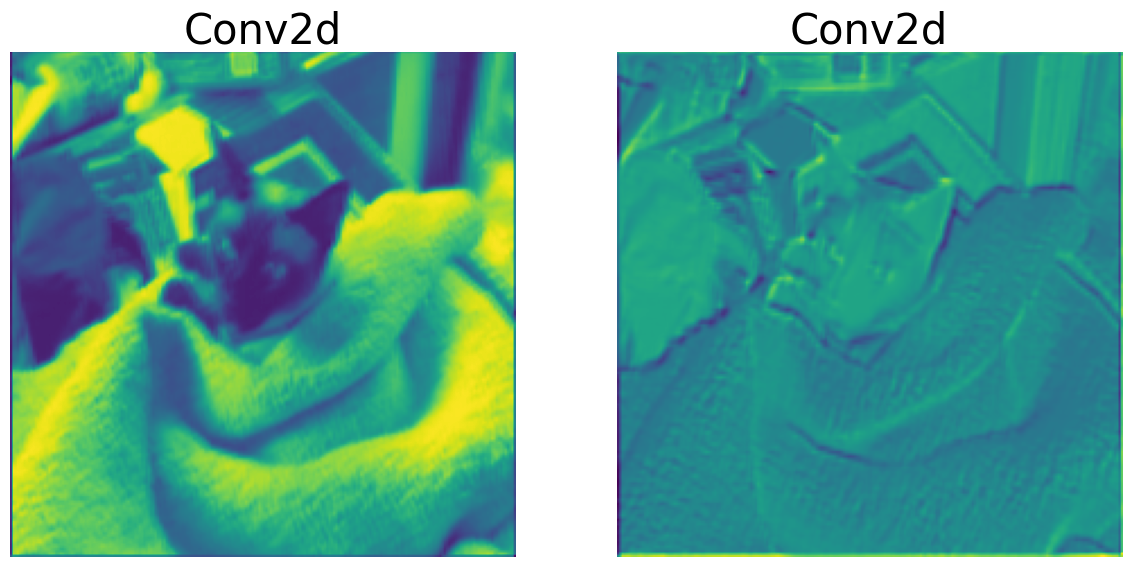

In [ ]:
# Training

import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, random_split
from torchvision import datasets
from torchvision.transforms.v2 import Resize
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

torch.manual_seed(42)

# ---------------------------------------------------------------------------------
# hyperparameters
# ---------------------------------------------------------------------------------
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 5

# helper vars
MODEL_OUT = 'model.pth'
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


# ---------------------------------------------------------------------------------
# helper funcs
# ---------------------------------------------------------------------------------
def evaluate(writer, step, dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # compute metrics
    test_loss /= num_batches
    correct /= size
    writer.add_scalar('Loss/Test', test_loss, step)
    writer.add_scalar('Accuracy/Test', correct, step)
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


def train_one_epoch(writer, step, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(DEVICE), y.to(DEVICE)

        # forward
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # compute metrics
    train_loss /= num_batches
    correct /= size
    writer.add_scalar('Loss/Train', train_loss, step)
    writer.add_scalar('Accuracy/Train', correct, step)
    print(
        f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")


def main():
    # -----------------------------------------------------------------------------
    # data
    # -----------------------------------------------------------------------------
    data = OxfordPets(
        None,
        target_types=['category'],
        transform=Resize((128, 128), antialias=True))
    train_data, test_data = random_split(data, (0.8, 0.2))

    # create samplers
    train_sampler = RandomSampler(train_data)
    test_sampler = SequentialSampler(test_data)

    # Create data loaders
    data_loader_train = DataLoader(
        train_data,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
    )
    data_loader_test = DataLoader(
        test_data,
        batch_size=1,
        sampler=test_sampler,
    )

    # ---------------------------------------------------------------------------------
    # model & optimizer
    # ---------------------------------------------------------------------------------
    model = NeuralNetwork().to(DEVICE)
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    num_params = count_parameters(model)
    print(num_params)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

    # ---------------------------------------------------------------------------------
    # logging
    # ---------------------------------------------------------------------------------
    writer = SummaryWriter()

    # ---------------------------------------------------------------------------------
    # training
    # ---------------------------------------------------------------------------------
    for t in range(EPOCHS):
        print(f"Epoch {t+1}\n-------------------------------")
        train_one_epoch(writer, t+1, data_loader_train,
                        model, loss_fn, optimizer)
        evaluate(writer, t+1, data_loader_test, model, loss_fn)
    writer.close()
    print("Done!")

    # ---------------------------------------------------------------------------------
    # save model
    # ---------------------------------------------------------------------------------
    torch.save(model.state_dict(), MODEL_OUT)
    print(f"Saved PyTorch Model State to {MODEL_OUT}")

    # ---------------------------------------------------------------------------------
    # feature map
    # ---------------------------------------------------------------------------------
    from torchvision import models, transforms, utils
    import numpy as np
    tensor_data = data_loader_train.dataset[1][0]

    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert numpy array to PIL Image
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0., std=1.)
    ])

    image = transform(tensor_data)
    print(f"Image shape before: {image.shape}")
    image = image.unsqueeze(0)
    print(f"Image shape after: {image.shape}")
    image = image.to(DEVICE)

    model = NeuralNetwork()
    model.load_state_dict(torch.load("model.pth", map_location=torch.device(DEVICE)))
    model.eval()

    # save the conv layer weights in this list
    model_weights =[]
    #save the  conv layers in this list
    conv_layers = []
    # get all the model children as list
    model_children = list(model.children())
    # counter to keep count of the conv layers
    counter = 0
    # append all the conv layers and their respective wights to the list
    for i in range(len(model_children)):
        try:
            for j in range(len(model_children[i])):
                print(model_children[i][j])


                if type(model_children[i][j]) == nn.Conv2d:
                    counter+=1
                    model_weights.append(model_children[i][j].weight)
                    conv_layers.append(model_children[i][j])
                elif type(model_children[i][j]) == nn.Sequential:
                    for j in range(len(model_children[i][j])):
                        for child in model_children[i][j].children():
                            if type(child) == nn.Conv2d:
                                counter+=1
                                model_weights.append(child.weight)
                                conv_layers.append(child)
        except:
            pass
    print(f"Total convolution layers: {counter}")
    print("conv_layers")

    outputs = []
    names = []
    for layer in conv_layers[0:]:
        layer = layer.to(DEVICE)
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
    print(len(outputs))

    #print feature_maps
    for feature_map in outputs:
        print(feature_map.shape)

    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
    for fm in processed:
        print(fm.shape)

    fig = plt.figure(figsize=(30, 50))
    for i in range(len(processed)):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title(names[i].split('(')[0], fontsize=30)
    plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

if __name__ == '__main__':
    main()
